### Here we design our basic chip in qiskit metal. This consists of:
1. a CPW with wirebond pads at both ends (this is static)
2. a CoupledLineTee on the CPW that defines the coupler (programmable length, width)
3. a CPW of some length and width hanging off the CPW

Later the LLM will need to be able to modify these parameters. It will also need access to
1. CPW widths
2. port locations on the CPW
3. access to each object's parameters
4. screenshots of the design (also provided by qiskit)

In [1]:
import qiskit_metal as metal
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond

design = designs.DesignPlanar()
design.overwrite_enabled = True
gui = MetalGUI(design)

cpw_width = 10e-3 # units are in um
cpw_gap = 10e-3 # units are in um

design.variables['cpw_width'] = cpw_width
design.variables['cpw_gap'] = cpw_gap


In [2]:
# begin by drawing the coupledlinetee (everything else branches off this)

# our parameters, that the LLM understands
coupler_gap = 20e-3
coupler_length = 100e-3

# the parameters that qiskit metal understands

coupler_options = {
    'prime_width': cpw_width,
    'prime_gap': cpw_gap,
    'second_width': cpw_width,
    'second_gap': cpw_gap,
    'coupling_space': coupler_gap - 2*cpw_gap,
    'coupling_length': coupler_length,
    'down_length': 50e-3,
    'fillet':10e-3,
    'orientation': -180
}

coupling_length = coupler_length


coupler = CoupledLineTee(design, 'coupler', options=coupler_options)

# GUI code to run after every change
gui.rebuild()
gui.autoscale()


In [3]:
# lastly add the meander. coupler / second_end is the port

# here we provide resonator_width, resonator_length, resonator_height. By default it is instantiated connected to the coupler port

# need the location of the coupler port

resonator_height = 1000e-3
resonator_length = 10000e-3


coupler_port_end_x = coupler.pins['second_end']['middle'][0]

end_short_meander = ShortToGround(design, 'end_short_meander', options=dict(pos_x=coupler_port_end_x, pos_y=resonator_height, orientation=90))

meander_options = Dict(pin_inputs=Dict(start_pin=Dict(
                                            component='coupler',
                                            pin='second_end'),
                                        end_pin=Dict(
                                            component='end_short_meander',
                                            pin='short')
                                        ),
                      total_length=resonator_length,
                      fillet=40e-3,
                      start_straight=100e-3,
                      end_straight=100e-3,
                      meander=Dict(spacing=100e-3))

meander = RouteMeander(design, 'meander', meander_options)

bounds = meander.qgeometry_bounds()
print(bounds)

box_bot = -100e-3
box_top = bounds[3] * 1.2
box_left = bounds[0] * 1.2
box_right = bounds[2] * 1.2


gui.rebuild()
gui.autoscale()

03:31PM 27s WARNING [check_lengths]: For path table, component=meander, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
03:31PM 27s WARNING [check_lengths]: For path table, component=meander, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
03:31PM 28s WARNING [check_lengths]: For path table, component=meander, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
03:31PM 28s WARNING [check_lengths]: For path table, component=meander, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.


[-0.63681416  0.08        0.53681417  1.        ]


In [4]:
# then we add the feedline and wirebonds

left_feedline_bound = bounds[0]*1.5
right_feedline_bound = bounds[2]*1.5

launch_left = LaunchpadWirebond(design, 'launch_left',  options = dict(pad_width = 100e-3, pad_height = 100e-3, pos_x = left_feedline_bound, pos_y=0, orientation=0))
launch_right = LaunchpadWirebond(design, 'launch_right',options = dict(pad_width = 100e-3, pad_height = 100e-3, pos_x = right_feedline_bound, pos_y=0, orientation=180))

print(launch_left)

pin_opt = Dict(pin_inputs=Dict(start_pin=Dict(
                                    component='launch_left',
                                    pin='tie'),
                                end_pin=Dict(
                                    component='launch_right',
                                    pin='tie')))


feedline = RouteStraight(design, 'feedline', pin_opt)

gui.rebuild()
gui.autoscale()


03:31PM 28s WARNING [check_lengths]: For path table, component=meander, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
03:31PM 28s WARNING [check_lengths]: For path table, component=meander, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.


name:    launch_left
class:   LaunchpadWirebond     
options: 
  'pos_x'             : -0.9552212474999999,          
  'pos_y'             : 0,                            
  'orientation'       : 0,                            
  'chip'              : 'main',                       
  'layer'             : '1',                          
  'trace_width'       : 'cpw_width',                  
  'trace_gap'         : 'cpw_gap',                    
  'lead_length'       : '25um',                       
  'pad_width'         : 0.1,                          
  'pad_height'        : 0.1,                          
  'pad_gap'           : '58um',                       
  'taper_height'      : '122um',                      
module:  qiskit_metal.qlibrary.terminations.launchpad_wb
id:      4



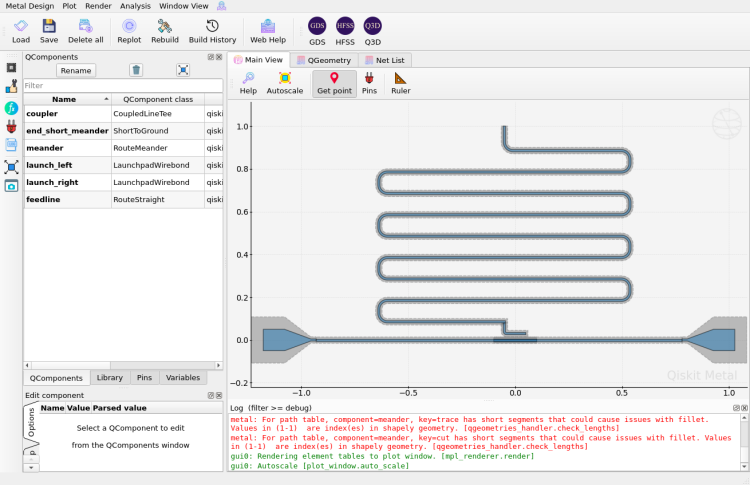

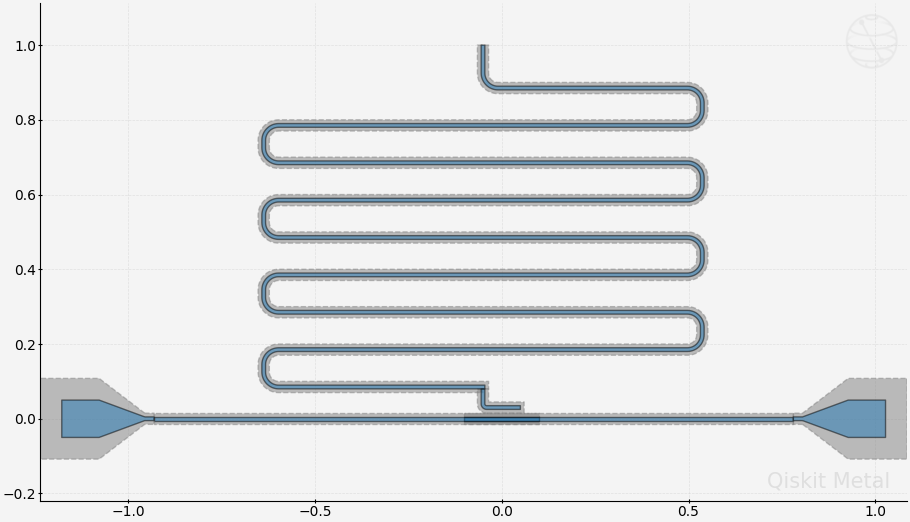

In [5]:
# take a screenshot
gui.screenshot()
gui.figure.savefig('shot.png')
from IPython.display import Image, display
_disp_ops = dict(width=500)
display(Image('shot.png', **_disp_ops))

In [6]:
# export to gds
design.renderers.gds.export_to_gds('resonator.gds')

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

  df_copy = df_copy.append(orig_row, ignore_index=False)

03:31PM 28s WARNING [_import_junction_gds_file]: Not able to find file:"../resources/Fake_Junctions.GDS".  Not used to replace junction. Checked directory:"/home/kaveh/Documents/stanfordphd/sum25/resources".


1

In [7]:
# then we need to boolean together the features
import manipulate_GDS
import numpy as np

manipulate_GDS.slice_and_boolean(inpath="resonator.gds", savepath="sonnet.gds", focus_box=np.array([[box_left, box_bot], [box_right, box_top]]), booleans={"layer 1": [(1,0),(1,0)], "layer 2": [(1,10),(1,11)], "layer out": [(100,0),(100,0)], "operation":['or','or']}, layers_to_save=[100])

slicing polygons from layer 1, datatype 10
slicing polygons from layer 1, datatype 11
slicing polygons from layer 1, datatype 0
slicing polygons from layer 1, datatype 102
slicing polygons from layer 1, datatype 101
slicing polygons from layer 1, datatype 100
slicing polygons from layer 1, datatype 99
preforming boolean 1
preforming boolean 2
adding polygons on layer 100, datatype 0...
